<a href="https://colab.research.google.com/github/YoonSungLee/Galaxies-Classification-By-Using-Deep-Learning/blob/master/Pratice_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브 mount

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# 패키지 불러오기

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
# 랜덤시드 고정
np.random.seed(3)

# 데이터 생성
# rescale: rescaling factor. Defaults to None.
# If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (before applying any other transformation).
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/train_galaxy', # 파일 경로
    target_size=(50,50), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/val_galaxy', # 파일 경로
    target_size=(50,50), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/test_galaxy', # 파일 경로
    target_size=(50,50), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

Found 10249 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


ImageDataGenerator를 이용하는 과정에서 batch_size의 결정이 하나의 이슈가 될 수 있다. 공개되어있는 많은 코드들을 보면 2의 제곱꼴의 형태로 이 값을 설정하는 것을 확인할 수 있다. 따라서 16으로 설정한다.

# Model 1

* AI Innovation Square에서 배운 CNN의 몇 가지 모델링 기법을 적용했다.
* feature map이 홀수가 되는 것을 방지하기 위해 첫 번째 Convolution Layer는 1개만 쌓는 방식을 택했다.
* 과적합을 방지하고 정규화를 위해 Convolution Layer 사이에 BatchNormalization을 적용했다.
* 기존의 CNN에서 feature map을 flatten하는 방식이 비효율적이라고 판단하여 새롭게 등장한 방법인 GlobalAveragePoolin2D를 적용하여 마지막 Layer와 연결했다(이는 각 feature map의 평균을 구해서 flatten처럼 길게 배열).
* 마지막 Layer에서 Dense Layer를 더 추가하지 않았다. 만약 추가한다면 Dense Layer 사이에 Dropout을 이용하여 과적합을 방지하는 전략을 써야 할 것이다.
* Convolution Layer : activation='relu'(CNN에서 좋은 효과를 보이는 활성화함수 적용)
* Convolution Layer : kernel_initializer='he_normal'(activation function을 relu로 설정했기 때문)
* Dense Layer : activation='softmax'(다중 분류문제이기 때문)

In [0]:
# 모델 설계

def create_model():
    n_kernels = 16
    model = Sequential()

    # N, 50, 50, 3
    model.add(Conv2D(n_kernels*2, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid', input_shape=(50,50,3)))
    # N, 48, 48, 32
    model.add(BatchNormalization())
    # N, 48, 48, 32
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 24, 24, 32
    model.add(Conv2D(n_kernels*2, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 22, 22, 32
    model.add(Conv2D(n_kernels*4, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 20, 20, 64
    model.add(BatchNormalization())
    # N, 20, 20, 64
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 10, 10, 64
    model.add(Conv2D(n_kernels*4, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 8, 8, 64
    model.add(Conv2D(n_kernels*8, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 6, 6, 128
    model.add(BatchNormalization())
    # N, 6, 6, 128
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 3, 3, 128

    model.add(GlobalAveragePooling2D())
    # N, 128
    model.add(Dense(3, activation='softmax'))
    # N, 3

    # 모델 학습과정 설정
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [0]:
# 학습 조기종료

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
# 최적 모델 선택 기법

filepath = '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/best_model-{epoch:02d}-{val_acc:.2f}.h5'
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)

epoch 당 시간이 많이 소요되기 때문에 전체 학습곡선을 보고 오버피팅 여부를 판단하기에는 너무나도 비효율적이다. 따라서 EarlyStopping을 통해 오버피팅을 스스로 감지하여 학습을 조기종료시키도록 설정하고, ModelCheckpoint를 통해 그 시점을 기준으로 지금까지 학습한 파라미터들 중 가장 좋은 성능을 보였던 파라미터를 가지고 있는 모델을 저장하도록 설정한다. 물론 오버피팅의 여부를 판단하는 patience라던지 ModelCheckpoint의 기준이 되는 'val_loss'는 개발자가 설정하는 값으로, 이 또한 하나의 이슈가 될 수 있다.

keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

* monitor : 관찰하고자 하는 항목입니다. ‘val_loss’나 ‘val_acc’가 주로 사용됩니다.
* min_delta : 개선되고 있다고 판단하기 위한 최소 변화량을 나타냅니다. 만약 변화량이 min_delta보다 적은 경우에는 개선이 없다고 판단합니다.
* patience : 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄 것인가를 지정합니다. 만약 10이라고 지정하면 개선이 없는 에포크가 10번째 지속될 경우 학습을 종료합니다.
* verbose : 얼마나 자세하게 정보를 표시할 것인가를 지정합니다. (0, 1, 2)
* mode : 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 지정합니다. 예를 들어 관찰 항목이 ‘val_loss’인 경우에는 감소되는 것이 멈출 때 종료되어야 하므로, ‘min’으로 설정됩니다.
 * auto : 관찰하는 이름에 따라 자동으로 지정합니다.
 * min : 관찰하고 있는 항목이 감소되는 것을 멈출 때 종료합니다.
 * max : 관찰하고 있는 항목이 증가되는 것을 멈출 때 종료합니다.

In [0]:
# 모델 생성

model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 64)       

In [0]:
# 모델 학습시키기

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=640,
    epochs=100,
    validation_data=val_generator,
    validation_steps=30,
    callbacks=[es,mc]
)

Epoch 1/100
640/640 [==============================] - 4587s 7s/step - loss: 0.5808 - acc: 0.7636 - val_loss: 0.6592 - val_acc: 0.7542
Epoch 2/100
640/640 [==============================] - 51s 80ms/step - loss: 0.4871 - acc: 0.8086 - val_loss: 0.4217 - val_acc: 0.8559
Epoch 3/100
640/640 [==============================] - 17s 27ms/step - loss: 0.4427 - acc: 0.8262 - val_loss: 0.4933 - val_acc: 0.8072
Epoch 4/100
640/640 [==============================] - 17s 26ms/step - loss: 0.4141 - acc: 0.8381 - val_loss: 0.4954 - val_acc: 0.8008
Epoch 5/100
640/640 [==============================] - 17s 26ms/step - loss: 0.3907 - acc: 0.8512 - val_loss: 0.3824 - val_acc: 0.8562
Epoch 6/100
640/640 [==============================] - 17s 26ms/step - loss: 0.3730 - acc: 0.8532 - val_loss: 0.3339 - val_acc: 0.8856
Epoch 7/100
640/640 [==============================] - 17s 26ms/step - loss: 0.3469 - acc: 0.8639 - val_loss: 0.4034 - val_acc: 0.8538
Epoch 8/100
640/640 [==============================] - 

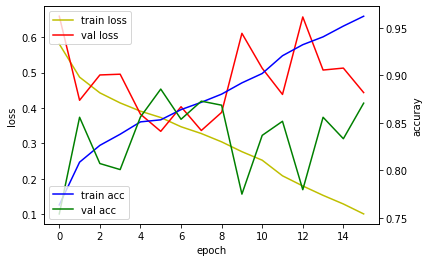

In [0]:
# 모델 학습 과정 표시하기

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Model 1 Feedback

* best_model-06-0.89.h5
* 모델 학습곡선을 살펴보면 train data에 대해서는 꾸준한 학습을 보이는 데 반해, validation data에 대해서는 결과값들이 들쭉날쭉하고 좋은 성능을 보이지 못하고 있다.
* fully-connected layer의 층을 두껍게 하고 Dropout을 추가하는 방법을 적용해볼 수 있다. 추가적으로 GlobalAveragePooling2D의 적용이 이 데이터셋에 대해서는 좋지 않은 성능을 보일 수 있으므로 단순히 Flatten을 적용하는 방법도 고려해볼 수 있다.
* 학습 조기종료가 상대적으로 빨리 이루어진듯한 느낌이 있다. 이는 Overfitting이 너무 빨리 이루어졌거나 Local Minimum Problem일 가능성이 있다. 이를 좀 더 잘 판단하기 위해 EarlyStopping의 patience을 조정해줄 필요가 있다.
* 위의 Feedback을 했는데도 큰 발전이 없다면 Convolution Layer의 구조를 바꿀 수 밖에 없다.

# Model 2

* fully-connected layer에 Dense Layer와 Dropout 2개를 추가했다.
* EarlyStopping의 patience을 20으로 늘려 학습 조기종료시간을 조금 더 늦췄다.

In [0]:
# 모델 설계

def create_model():
    n_kernels = 16
    model = Sequential()

    # N, 50, 50, 3
    model.add(Conv2D(n_kernels*2, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid', input_shape=(50,50,3)))
    # N, 48, 48, 32
    model.add(BatchNormalization())
    # N, 48, 48, 32
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 24, 24, 32
    model.add(Conv2D(n_kernels*2, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 22, 22, 32
    model.add(Conv2D(n_kernels*4, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 20, 20, 64
    model.add(BatchNormalization())
    # N, 20, 20, 64
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 10, 10, 64
    model.add(Conv2D(n_kernels*4, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 8, 8, 64
    model.add(Conv2D(n_kernels*8, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 6, 6, 128
    model.add(BatchNormalization())
    # N, 6, 6, 128
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 3, 3, 128

    model.add(GlobalAveragePooling2D())
    # N, 128
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    # N, 128
    model.add(Dropout(0.3))
    # N, 128
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    # N, 128
    model.add(Dropout(0.3))
    # N, 128
    model.add(Dense(3, activation='softmax', kernel_initializer='he_normal'))
    # N, 3

    # 모델 학습과정 설정
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

# 학습 조기종료

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# 최적 모델 선택 기법

filepath = '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/best_model2-{epoch:02d}-{val_acc:.2f}.h5'
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)

# 모델 생성

model = create_model()
model.summary()

# 모델 학습시키기

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=640,
    epochs=100,
    validation_data=val_generator,
    validation_steps=30,
    callbacks=[es,mc]
)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 20, 64)        256       
_____

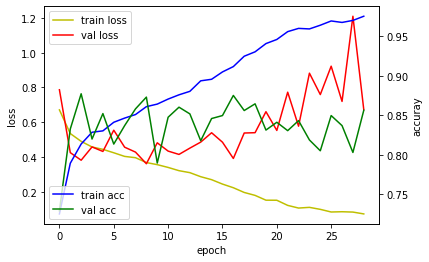

In [0]:
# 모델 학습 과정 표시하기

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Model 2 Feedback

* best_model2-09-0.87.h5
* Model 1과 비교하여 아주 미세하게 튀는 현상이 줄긴 했지만 여전히 validation data에 대해서 불안정한 결과가 많이 보인다.
* fully-connected layer의 층을 쌓은 효과를 보지 못했다. 다른 방법으로는 GlobalAveragePooling2D 대신에 단순히 Flatten을 적용하여 feature map을 1차원 데이터로 펼치는 방법이다. GlobalAveragePooling2D이 Flatten보다 이미지 데이터에 대하여 좋은 성능을 보인다고는 하지만 모델링 방법에 따라 그리고 이미지 데이터의 특성에 따라 얼마든지 예외인 경우가 있을 수 있다.
* 또한 마찬가지로 Overfitting 또는 Local Minimum Problem 등의 문제로 적은 수의 epoch으로 학습 조기 중단이 발생했다. 파라미터를 미세하게 수정할 필요가 있다.

# Model 3

* fully-connected layer에서 GlobalAveragePooling2D 대신에 Flatten을 사용했다.
* EarlyStopping의 patience을 30으로 늘려 학습 조기종료시간을 조금 더 늦췄다.

In [0]:
# 모델 설계

def create_model():
    n_kernels = 16
    model = Sequential()

    # N, 50, 50, 3
    model.add(Conv2D(n_kernels*2, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid', input_shape=(50,50,3)))
    # N, 48, 48, 32
    model.add(BatchNormalization())
    # N, 48, 48, 32
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 24, 24, 32
    model.add(Conv2D(n_kernels*2, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 22, 22, 32
    model.add(Conv2D(n_kernels*4, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 20, 20, 64
    model.add(BatchNormalization())
    # N, 20, 20, 64
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 10, 10, 64
    model.add(Conv2D(n_kernels*4, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 8, 8, 64
    model.add(Conv2D(n_kernels*8, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 6, 6, 128
    model.add(BatchNormalization())
    # N, 6, 6, 128
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 3, 3, 128
    model.add(Conv2D(n_kernels*8, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='valid'))
    # N, 1, 1, 128
    model.add(BatchNormalization())
    # N, 1, 1, 128

    model.add(Flatten())
    # N, 128
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    # N, 128
    model.add(Dropout(0.3))
    # N, 128
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    # N, 128
    model.add(Dropout(0.3))
    # N, 128
    model.add(Dense(3, activation='softmax', kernel_initializer='he_normal'))
    # N, 3

    # 모델 학습과정 설정
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

# 학습 조기종료

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# 최적 모델 선택 기법

filepath = '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/best_model3-{epoch:02d}-{val_acc:.2f}.h5'
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)

# 모델 생성

model = create_model()
model.summary()

# 모델 학습시키기

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=640,
    epochs=100,
    validation_data=val_generator,
    validation_steps=30,
    callbacks=[es,mc]
)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 64)        25

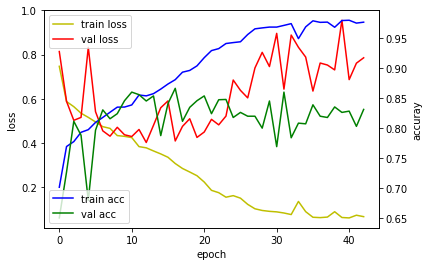

In [0]:
# 모델 학습 과정 표시하기

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Model 3 Feedback

* best_model3-13-0.85.h5
* Model 2와 비교하여 학습곡선이 더욱 불안정하고 val_loss와 val_acc 또한 더 좋지 않은 결과를 보이고 있다. 이로써 Flatten보다는 GlobalAveragePooling2D가 더 좋은 효과를 낸다는 것을 확인할 수 있었다.
* fully-connected layer에서 문제가 없다면 결국 Convolution Layer를 손댈 수 밖에 없다. Image 분야에서 좋은 성능을 낸 모델들의 구성과 비슷하게 만들어보는 방법이 있고, 그냥 그 모델 그대로 가져와서 학습하는 방법이 있다. 모델링에 초점을 맞추어 Convolution Layer의 구성을 바꾸는 방법을 택하기로 한다.

# Model 4

* 한때 Image데이터에 대단한 성능을 보였던 VGG16 모델을 개조한 모델이다.
* VGG16은 input data의 shape이 (224,224)로 고정되어있으므로 ImageDataGenerator 인스턴스들의 target_size를 알맞게 조정해준다.
* 모든 layer의 activation function을 'relu'로, kernel initializer를 'he_normal'로 설정했다.
* Convolution - Convolution - MaxPooling을 한 블록이라고 한다면, 블록과 블록 사이에 BatchNormalization을 적용하여 모델의 성능을 높이고자 했다.
* 기존 VGG16의 bottleneck을 완화하기 위해 Maxpooling2D를 하기 전에 filter의 수를 미리 2배로 늘려주었다.
* 기존 VGG16의 fully-connected layer의 Flatten 대신 GlobalAveragePooling2D를 사용하고, 이에 따라 Dense layer의 units 또한 적절히 수정했다.
* fully-connected layer의 Dense layer 사이에 Dropout을 적용하여 Dense layer들의 Overfitting을 방지하고자 했다.

In [0]:
# 랜덤시드 고정
np.random.seed(3)

# 데이터 생성
# rescale: rescaling factor. Defaults to None.
# If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (before applying any other transformation).
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/train_galaxy', # 파일 경로
    target_size=(224,224), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/val_galaxy', # 파일 경로
    target_size=(224,224), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/test_galaxy', # 파일 경로
    target_size=(224,224), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

Found 10249 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [0]:
# 모델 설계

def create_model():
    n_kernels = 16
    model = Sequential()

    # N, 224, 224, 3
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(224,224,3)))
    # N, 224, 224, 64
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 224, 224, 128
    model.add(BatchNormalization())
    # N, 224, 224, 128
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 112, 112, 128

    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 112, 112, 128
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 112, 112, 256
    model.add(BatchNormalization())
    # N, 112, 112, 256
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 56, 56, 256

    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 56, 56, 256
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 56, 56, 256
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 56, 56, 512
    model.add(BatchNormalization())
    # N, 56, 56, 512
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 28, 28, 512

    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 28, 28, 512
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 28, 28, 512
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 28, 28, 512
    model.add(BatchNormalization())
    # N, 28, 28, 512
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 14, 14, 512

    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 14, 14, 512
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 14, 14, 512
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
    # N, 14, 14, 512
    model.add(BatchNormalization())
    # N, 14, 14, 512
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 7, 7, 512

    model.add(GlobalAveragePooling2D())
    # N, 512
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    # N, 512
    model.add(Dropout(0.3))
    # N, 512
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    # N, 512
    model.add(Dropout(0.3))
    # N, 512
    model.add(Dense(3, activation='softmax', kernel_initializer='he_normal'))
    # N, 3


    # 모델 학습과정 설정
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

# 학습 조기종료

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# 최적 모델 선택 기법

filepath = '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/best_model4-{epoch:02d}-{val_acc:.2f}.h5'
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)

# 모델 생성

model = create_model()
model.summary()

# 모델 학습시키기

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=640,
    epochs=100,
    validation_data=val_generator,
    validation_steps=30,
    callbacks=[es,mc]
)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 256)     29

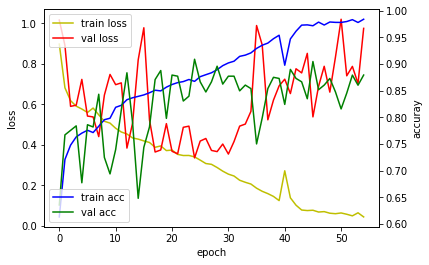

In [0]:
# 모델 학습 과정 표시하기

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Model 4 Feedback

* best_model4-25-0.91.h5
* ModelCheckpoint를 통해 저장된 모델을 기준으로 했을 때 이전 모델들에 비해서 좋은 성능을 낸 것은 맞다. 하지만 학습곡선을 두고 봤을 땐 오히려 더 불안정한 경향이 있다. 쌓은 layer에 비해 큰 성능을 내지 못하고 있다.
* AI Innovation Square에서 배운 내용을 바탕으로 한 가지 모델을 더 실험할 계획이다. 먼저 모든 Convolution가 통과된 이후 BatchNormalization을 적용시킨다. 또한 BatchNormalization의 파라미터가 Convolution Layer의 bias 역할을 대신 해주므로 모든 Convolution Layer의 bias를 제거시켜준다(use_bias=False).
* 추가적으로 EarlyStopping이 너무 늦다고 판단하여 patience 조절이 필요하다.


# Model 5

* Model 4의 Convolution Layer의 구조를 Conv2D-BN-Conv2D-BN-MaxPooling2D 형식으로 바꾼다.
* Convolution Layer의 bias를 제거시킨다.

In [6]:
# 랜덤시드 고정
np.random.seed(3)

# 데이터 생성
# rescale: rescaling factor. Defaults to None.
# If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (before applying any other transformation).
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/train_galaxy', # 파일 경로
    target_size=(224,224), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/val_galaxy', # 파일 경로
    target_size=(224,224), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/test_galaxy', # 파일 경로
    target_size=(224,224), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

Found 10249 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [7]:
# 모델 설계

def create_model():
    n_kernels = 16
    model = Sequential()

    # N, 224, 224, 3
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False, input_shape=(224,224,3)))
    # N, 224, 224, 64
    model.add(BatchNormalization())
    # N, 224, 224, 64
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 224, 224, 128
    model.add(BatchNormalization())
    # N, 224, 224, 128
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 112, 112, 128

    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 112, 112, 128
    model.add(BatchNormalization())
    # N, 112, 112, 128
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 112, 112, 256
    model.add(BatchNormalization())
    # N, 112, 112, 256
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 56, 56, 256

    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 56, 56, 256
    model.add(BatchNormalization())
    # N, 56, 56, 256
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 56, 56, 256
    model.add(BatchNormalization())
    # N, 56, 56, 256
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 56, 56, 512
    model.add(BatchNormalization())
    # N, 56, 56, 512
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 28, 28, 512

    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 28, 28, 512
    model.add(BatchNormalization())
    # N, 28, 28, 512
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 28, 28, 512
    model.add(BatchNormalization())
    # N, 28, 28, 512
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 28, 28, 512
    model.add(BatchNormalization())
    # N, 28, 28, 512
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 14, 14, 512

    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 14, 14, 512
    model.add(BatchNormalization())
    # N, 14, 14, 512
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 14, 14, 512
    model.add(BatchNormalization())
    # N, 14, 14, 512
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same', use_bias=False))
    # N, 14, 14, 512
    model.add(BatchNormalization())
    # N, 14, 14, 512
    model.add(MaxPooling2D(pool_size=(2,2)))
    # N, 7, 7, 512

    model.add(GlobalAveragePooling2D())
    # N, 512
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    # N, 512
    model.add(Dropout(0.3))
    # N, 512
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    # N, 512
    model.add(Dropout(0.3))
    # N, 512
    model.add(Dense(3, activation='softmax', kernel_initializer='he_normal'))
    # N, 3


    # 모델 학습과정 설정
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

# 학습 조기종료

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# 최적 모델 선택 기법

filepath = '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/best_model5-{epoch:02d}-{val_acc:.2f}.h5'
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)

# 모델 생성

model = create_model()
model.summary()

# 모델 학습시키기

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=640,
    epochs=100,
    validation_data=val_generator,
    validation_steps=30,
    callbacks=[es,mc]
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 224, 224, 64)      1728      
_________________________________________________________________
batch_normalization_14 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 128)     73728     
_________________________________________________________________
batch_normalization_15 (Batc (None, 224, 224, 128)     512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147456    
_________________________________________________________________
batch_normalization_16 (Batc (None, 112, 112, 128)    

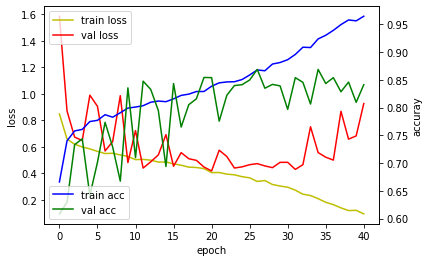

In [8]:
# 모델 학습 과정 표시하기

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [0]:
# 모델 평가
# 학습한 모델을 평가해봅니다. 제네레이터에서 제공되는 샘플로 평가할 때는 evaluate_generator 함수를 사용합니다.

best_model = keras.models.load_model('')

print('--Evaluate--')
scores = best_model.evaluate_generator(test_generator, steps=30)
print("%s: %.2f%%" %(best_model.metrics_names[1], scores[1]*100))

In [0]:
# 모델 사용하기
# 모델 사용 시에 제네레이터에서 제공되는 샘플을 입력할 때는 predict_generator 함수를 사용합니다.
# 예측 결과는 클래스별 확률 벡터로 출력되며, 클래스에 해당하는 열을 알기 위해서는 제네레이터의 ‘class_indices’를 출력하면 해당 열의 클래스명을 알려줍니다.

print("-- Predict --")
output = best_model.predict_generator(test_generator, steps=30)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

### 학습 조기종료 시키기
* https://tykimos.github.io/2017/07/09/Early_Stopping/
* https://3months.tistory.com/424